In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE=32 # kitne data hai har ek batch me example file have 100 photos and batch size is 10 then ek baar me bs 10 photo jayega training me
IMAGE_SIZE=256
CHANNEL=3 # defining color type (RGB hai yaha apne pass thats why channel =3)
EPOCH=50 # number iteration for training


In [3]:
# making the object of Data Base file show that we can use it in better or batch mananer efficiently
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"Data_Base",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)


Found 2152 files belonging to 3 classes.


In [4]:
# dekh rha hai iss directory or konse sb file or directory hai
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
dataset.take(1) 

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
# batch ke deatils print kr rhe hai

for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape) # ye batata hai ke 32(files hai) 256(height and width) and channel 3 hai (RGB)
    print(labels_batch.numpy()) # Ye hamare files ko show kar rha hai from data base --> 0 for early_blight , 1 for late and 2 healty

(32, 256, 256, 3)
[1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1]


## Data Visualization

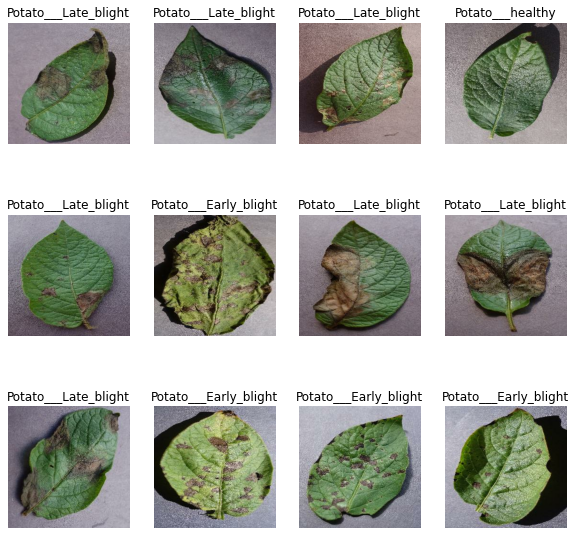

In [7]:
plt.figure(figsize=(10,10)) # defining the size of the image

for image_batch,labels_batch in dataset.take(1):
    for i in range(12): # 32 me se sirf 12 image print kro
        
        ax= plt.subplot(3,4,i+1) # dimesion of every image
        plt.imshow(image_batch[i].numpy().astype("uint8")) # changing the image array into actual image
        
        plt.title(class_name[labels_batch[i]])
        plt.axis("off") 

# Data spliting for Train and Test
 * 80% ==> Training
 * 20%==>  Test
   *  10%==> Validation (har ek epoch pe cross check krne keliye)
    * 10%==> test (final test keliye)

In [8]:
len(dataset) # iska matlab 68* 32==> itne photos h apne file me


68

In [9]:
train_size= 0.8
len(dataset)* train_size # for 80% we need to take 54 file of batch 32 (54*32--> photos)

54.400000000000006

In [10]:
# Now train test split
train_ds= dataset.take(54) # use take first 54 like arr[:54]

test_ds= dataset.skip(54)  # similar to the arr[54:]

print(len(train_ds))
print(len(test_ds))

# Now we want to split the test data set into test and validation

54
14


In [11]:
# so Making the train and test split in function 

def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + val_split + test_split)==1 # so that user doesn't  fill the wrong percentage like .5, .5, .5 for test,train and valid
    
    ds_size=len(ds)
    
    if shuffle: 
        ds=ds.shuffle(shuffle_size, seed=12)
        
    
    train_size= int(train_split* ds_size)
    val_size= int(val_split* ds_size)
    
    train_ds= ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

print(len(train_ds))
print(len(test_ds))

54
8


In [13]:
# cache isliye karte taki jo image kaam karega usse memory me rakhega taki training me speed mile ( time save krta hai image ko memory me rakh ke)
# shuffle isliye karte hai taki performance better ata hai 

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
#showing the image in the form of the array
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[162. 164. 177.]
  [175. 177. 190.]
  [183. 185. 198.]
  ...
  [137. 135. 149.]
  [ 88.  86. 100.]
  [208. 206. 220.]]

 [[174. 176. 189.]
  [174. 176. 189.]
  [171. 173. 186.]
  ...
  [ 90.  88. 102.]
  [115. 113. 127.]
  [122. 120. 134.]]

 [[163. 165. 178.]
  [166. 168. 181.]
  [173. 175. 188.]
  ...
  [ 85.  83.  97.]
  [104. 102. 116.]
  [ 88.  86. 100.]]

 ...

 [[137. 139. 152.]
  [133. 135. 148.]
  [138. 140. 153.]
  ...
  [118. 120. 132.]
  [123. 125. 137.]
  [120. 122. 134.]]

 [[144. 146. 159.]
  [136. 138. 151.]
  [138. 140. 153.]
  ...
  [ 96.  98. 110.]
  [108. 110. 122.]
  [ 80.  82.  94.]]

 [[146. 148. 161.]
  [136. 138. 151.]
  [134. 136. 149.]
  ...
  [127. 129. 141.]
  [104. 106. 118.]
  [120. 122. 134.]]]


# Creating a Layer for Resizing and Normalization
* Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

* You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [15]:
# as we can see the image range b/w 1 to 256 as we defined earlier

#--> so we need to normalize this range for better and fast computation (normalization change the range b/w 0 to 1)

# to normalize we will crate a layer using keras and tansorflow

resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), # ye resize karega 256 
    layers.experimental.preprocessing.Rescaling(1.0/255) # or ye normalize karega
])

In [16]:
# here we are creating a layer of data augmentation 

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # it will give the fliped images
    layers.experimental.preprocessing.RandomRotation(0.2) # it will give rotated image
    
])

# Model Training and Building (architecture)

In [17]:
# see the CNN video of codebasic

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

# one by one we are adding the layers we created and apart from that we also doing pooling , at the end we did flaten
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), # creating CNN and using Relu activation fucntion
    
    layers.MaxPooling2D((2, 2)), #pooling
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(), #flating the 2d array into 1d array
    layers.Dense(64, activation='relu'), # adding the dense layer at 2nd last step
    
    layers.Dense(n_classes, activation='softmax'), # final neuron (but we have 3 class of output i.e healthy, early blight,and late blight)
    
])

model.build(input_shape=input_shape)

In [18]:
model.summary() # giving the summary of every layers

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# optimizing and compiling the model

In [19]:
model.compile(
optimizer='adam', # optimizer algo
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [20]:
# fiting the data into the model and TRAINING IT

history= model.fit( # history will store the every training epoches
train_ds,
batch_size=BATCH_SIZE,
validation_data=val_ds,
verbose=1,
epochs= EPOCH)

Epoch 1/50
54/54 [==============================] - 128s 2s/step - loss: 0.8368 - accuracy: 0.5382 - val_loss: 0.5726 - val_accuracy: 0.7656
Epoch 2/50
54/54 [==============================] - 125s 2s/step - loss: 0.5969 - accuracy: 0.7413 - val_loss: 0.4671 - val_accuracy: 0.8229
Epoch 3/50
54/54 [==============================] - 119s 2s/step - loss: 0.4762 - accuracy: 0.7986 - val_loss: 0.2939 - val_accuracy: 0.8958
Epoch 4/50
54/54 [==============================] - 117s 2s/step - loss: 0.3284 - accuracy: 0.8681 - val_loss: 0.3474 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 117s 2s/step - loss: 0.2506 - accuracy: 0.8947 - val_loss: 0.1779 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 116s 2s/step - loss: 0.1980 - accuracy: 0.9213 - val_loss: 0.1470 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 102s 2s/step - loss: 0.1663 - accuracy: 0.9340 - val_loss: 0.0981 - val_accuracy: 0.9635
Epoch 8/50
54

# Testing the Model

In [21]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 5s 348ms/step - loss: 0.0524 - accuracy: 0.9883
Test Accuracy: 98.83%


# Plotting the Accuracy and Loss Curves

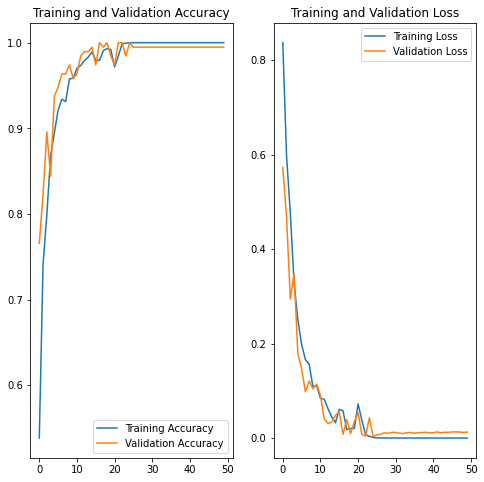

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
Actual label: 1
1/1 [==============================] - 0s 498ms/step
Prediction Label: 0


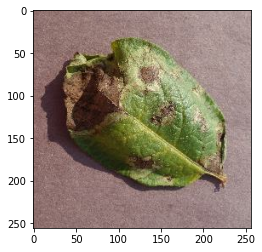

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image= images_batch[0].numpy().astype("uint8")
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label:", labels_batch[0].numpy())
    
    batch_prediction= model.predict(image_batch)
    print("Prediction Label:", np.argmax(batch_prediction[0]))

# Saving the Model

In [36]:
import os 
model.save(r"C:\Users\TOUT\Documents\MY PROJECT\Potato Disease Classification")

INFO:tensorflow:Assets written to: C:\Users\TOUT\Documents\MY PROJECT\Potato Disease Classification\assets


INFO:tensorflow:Assets written to: C:\Users\TOUT\Documents\MY PROJECT\Potato Disease Classification\assets
